In [1]:
import scanpy as sc
import scirpy as ir
import pandas as pd
import torch
import yaml
import numpy as np

In [2]:
import sys
sys.path.append('../')
import tcr_embedding as tcr

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
experiment_name = 'example'
with open(f'../config/{experiment_name}.yaml') as file:
     params = yaml.load(file, Loader=yaml.FullLoader)
params

{'seq_model_arch': 'dummy',
 'seq_model_hyperparams': {'stride': 1, 'pad': 1, 'kernel_size': 3},
 'zdim': 16,
 'hdim': 256,
 'activation': 'relu',
 'output_activation': 'linear',
 'dropout': 0.2,
 'batch_norm': True,
 'gene_hidden': [512],
 'shared_hidden': [64]}

# Load dataset

### Wu 2020 3k (toy dataset from Scirpy)

In [5]:
wu2020 = sc.read_h5ad('../data/Wu_2020/wu2020_3k.h5ad')
wu2020

AnnData object with n_obs × n_vars = 3000 × 30727
    obs: 'cluster_orig', 'patient', 'sample', 'source', 'clonotype_orig', 'multi_chain', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_junction_ins', 'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins', 'IR_VDJ_2_junction_ins', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'has_ir', 'batch'
    var: 'gene_ids', 'feature_types'
    obsm: 'X_umap_orig'

In [6]:
pd.set_option('display.max_columns', None)
wu2020.obs

,cluster_orig,patient,sample,source,clonotype_orig,multi_chain,IR_VJ_1_locus,IR_VJ_2_locus,IR_VDJ_1_locus,IR_VDJ_2_locus,IR_VJ_1_cdr3,IR_VJ_2_cdr3,IR_VDJ_1_cdr3,IR_VDJ_2_cdr3,IR_VJ_1_junction_ins,IR_VJ_2_junction_ins,IR_VDJ_1_junction_ins,IR_VDJ_2_junction_ins,IR_VJ_1_expr,IR_VJ_2_expr,IR_VDJ_1_expr,IR_VDJ_2_expr,IR_VJ_1_v_gene,IR_VJ_2_v_gene,IR_VDJ_1_v_gene,IR_VDJ_2_v_gene,IR_VJ_1_d_gene,IR_VJ_2_d_gene,IR_VDJ_1_d_gene,IR_VDJ_2_d_gene,IR_VJ_1_j_gene,IR_VJ_2_j_gene,IR_VDJ_1_j_gene,IR_VDJ_2_j_gene,IR_VJ_1_c_gene,IR_VJ_2_c_gene,IR_VDJ_1_c_gene,IR_VDJ_2_c_gene,IR_VJ_1_cdr3_nt,IR_VJ_2_cdr3_nt,IR_VDJ_1_cdr3_nt,IR_VDJ_2_cdr3_nt,has_ir,batch
LN1_GTAGGCCAGCGTAGTG-1-19,4.4-FOS,Lung1,LN1,NAT,lung1.tn.C223,False,nan,nan,TRB,TRB,None,None,CASSLMRLAGDTQYF,CASRLAVLSTSGSVGETQYF,None,None,None,None,NaN,nan,3.0,2.0,nan,nan,TRBV7-2,TRBV12-3,NaN,nan,TRBD2,TRBD2,nan,nan,TRBJ2-3,TRBJ2-5,nan,nan,TRBC2,TRBC2,None,None,TGTGCCAGCAGCTTAATGCGGCTAGCGGGAGATACGCAGTATTTT,TGTGCAAGTCGCTTAGCGGTTTTATCGACTAGCGGGAGTGTCGGAG...,True,19
RN2_AGAGCGACAGATTGCT-1-27,4.4-FOS,Renal2,RN2,NAT,renal2.tnb.C1362,False,TRA,nan,TRB,nan,CAVRGNNNARLMF,None,CASSFGTVAEAFF,None,None,None,None,None,1.0,nan,4.0,nan,TRAV8-6,nan,TRBV7-9,nan,None,nan,None,nan,TRAJ31,nan,TRBJ1-1,nan,TRAC,nan,TRBC1,nan,TGTGCTGTGAGGGGGAATAACAATGCCAGACTCATGTTT,None,TGTGCCAGCAGCTTTGGAACGGTGGCTGAAGCTTTCTTT,None,True,27
LN1_GTCATTTCAATGAAAC-1-19,8.2-Tem,Lung1,LN1,NAT,lung1.tn.C25,False,TRA,nan,TRB,nan,CAVRLGNQFYF,None,CSARDGGGGNTEAFF,None,None,None,None,None,2.0,nan,6.0,nan,TRAV21,nan,TRBV20-1,nan,None,nan,TRBD2,nan,TRAJ49,nan,TRBJ1-1,nan,TRAC,nan,TRBC1,nan,TGTGCTGTGAGGTTGGGTAACCAGTTCTATTTT,None,TGCAGTGCTAGAGATGGAGGGGGGGGGAACACTGAAGCTTTCTTT,None,True,19
LN2_GACACGCAGGTAGCTG-2-2,8.6-KLRB1,Lung2,LN2,NAT,lung2.tn.C2452,False,nan,nan,TRB,nan,None,None,CASSQGQGQDFNYEQYF,None,None,None,None,None,NaN,nan,15.0,nan,nan,nan,TRBV4-2,nan,NaN,nan,TRBD1,nan,nan,nan,TRBJ2-7,nan,nan,nan,TRBC2,nan,None,None,TGTGCCAGCAGCCAAGGTCAGGGACAGGATTTTAACTACGAGCAGT...,None,True,2
LN2_GCACTCTCAGGGATTG-2-2,4.4-FOS,Lung2,LN2,NAT,lung2.tn.C5631,False,TRA,nan,TRB,nan,CAASDPTVEAGTALIF,None,CASSLTVNTEAFF,None,None,None,None,None,4.0,nan,26.0,nan,TRAV23DV6,nan,TRBV7-2,nan,None,nan,None,nan,TRAJ15,nan,TRBJ1-1,nan,TRAC,nan,TRBC1,nan,TGTGCAGCAAGCGACCCCACGGTCGAGGCAGGAACTGCTCTGATCTTT,None,TGTGCCAGCAGCTTGACCGTTAACACTGAAGCTTTCTTT,None,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RT3_GCAGTTAGTATGAAAC-1-6,4.2-RPL32,Renal3,RT3,Tumor,renal3.tnb.C176,False,TRA,nan,TRB,nan,CAAMDSNYQLIW,None,CATKDREDTGELFF,None,None,None,None,None,1.0,nan,2.0,nan,TRAV1-2,nan,TRBV6-4,nan,None,nan,TRBD1,nan,TRAJ33,nan,TRBJ2-2,nan,TRAC,nan,TRBC2,nan,TGTGCTGCGATGGATAGCAACTATCAGTTAATCTGG,None,TGTGCCACCAAGGACAGGGAAGACACCGGGGAGCTGTTTTTT,None,True,6
LT1_GACGTGCTCTCAAGTG-1-24,8.2-Tem,Lung1,LT1,Tumor,lung1.tn.C151,False,TRA,nan,nan,nan,CAYRSSLGGATNKLIF,None,None,None,None,None,None,None,1.0,nan,NaN,nan,TRAV38-2DV8,nan,nan,nan,None,nan,nan,nan,TRAJ32,nan,nan,nan,TRAC,nan,nan,nan,TGTGCTTATAGGAGTTCCCTTGGTGGTGCTACAAACAAGCTCATCTTT,None,None,None,True,24
ET3_GCTGGGTAGACCTTTG-1-3,3.1-MT,Endo3,ET3,Tumor,endo3.tn.C76,False,nan,nan,TRB,nan,None,None,CASSRTGGDSGELFF,None,None,None,None,None,NaN,nan,6.0,nan,nan,nan,TRBV7-6,nan,NaN,nan,TRBD1,nan,nan,nan,TRBJ2-2,nan,nan,nan,TRBC2,nan,None,None,TGTGCCAGCAGCCGGACAGGGGGGGATTCCGGGGAGCTGTTTTTT,None,True,3
RT1_TAAGAGATCCTTAATC-1-8,4.5-IL6ST,Renal1,RT1,Tumor,renal1.tnb.C83,False,TRA,nan,TRB,nan,CAMSEISGGYNKLIF,None,CAWSDRSDEQYF,None,None,None,None,None,5.0,nan,4.0,nan,TRAV12-3,nan,TRBV30,nan,None,nan,TRBD1,nan,TRAJ4,nan,TRBJ2-7,nan,TRAC,nan,TRBC2,nan,TGTGCAATGAGCGAGATTTCTGGTGGCTACAATAAGCTGATTTTT,None,TGTGCCTGGAGTGACAGGTCAGACGAGCAGTACTTC,None,True,8


In [7]:
sc.pp.filter_genes(wu2020, min_cells=50)
sc.pp.filter_cells(wu2020, min_genes=100)
wu2020.shape

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(3000, 8587)

In [8]:
wu2020 = wu2020[wu2020.obs['has_ir'] == 'True']
wu2020 = wu2020[wu2020.obs['multi_chain'] != 'True']
wu2020.shape

(2983, 8587)

### BCC Dataset

In [9]:
bcc = sc.read_h5ad('../data/BCC_Yost_2018/bcc_tcr_and_gene.h5ad')
bcc

AnnData object with n_obs × n_vars = 53030 × 23309
    obs: 'patient', 'treatment', 'sort', 'cluster', 'UMAP1', 'UMAP2', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_junction_ins', 'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins', 'IR_VDJ_2_junction_ins', 'has_ir', 'multi_chain', 'patient_tcr', 'treatment_tcr', 'cluster_tcr', 'UMAP1_tcr', 'UMAP2_tcr'

In [10]:
sc.pp.filter_genes(bcc, min_cells=2000)
sc.pp.filter_cells(bcc, min_genes=2000)
bcc.shape

(14214, 9038)

In [11]:
# Filter samples without IR and multichain
bcc = bcc[bcc.obs['has_ir'] == 'True']
bcc = bcc[bcc.obs['multi_chain'] != 'True']
bcc.shape

(6275, 9038)

### Create inner join between gene expression
Filter annData based on inner join and change order to be the same

In [12]:
inner_join = list(set(bcc.var.index.to_list()) & set(wu2020.var.index.to_list()))
inner_join

['LYST',
 'DRG1',
 'SIN3A',
 'HIPK1',
 'NAA20',
 'MED13L',
 'CLK2',
 'SELK',
 'IRF5',
 'TOR1AIP2',
 'SUCO',
 'DNAJC11',
 'MRPS31',
 'MKNK2',
 'LYSMD2',
 'C12orf49',
 'COX7A2L',
 'GSTM3',
 'TMEM120B',
 'DUT',
 'ITGB3BP',
 'YES1',
 'CXCR5',
 'CLIC5',
 'NUFIP1',
 'TYW3',
 'SEC24C',
 'SDF4',
 'GALNT2',
 'SLAMF6',
 'LSM14A',
 'PTPN7',
 'PEX13',
 'ITPRIPL1',
 'DCTN4',
 'CD84',
 'EIF3I',
 'CHPF',
 'TMEM161A',
 'ZNF43',
 'LZTR1',
 'NNT-AS1',
 'CIZ1',
 'RNASEK',
 'NCR3',
 'VAMP1',
 'TUBGCP6',
 'HERC1',
 'RHNO1',
 'JAK2',
 'LGALS3BP',
 'HDGF',
 'BLVRB',
 'TAB3',
 'NAA35',
 'CALCOCO2',
 'DOK1',
 'KIAA1109',
 'GID8',
 'ERC1',
 'SEC16A',
 'PCNXL2',
 'NUP133',
 'SLC25A33',
 'SLC35C2',
 'WHSC1',
 'ZCCHC2',
 'BRIX1',
 'CCT7',
 'ATF4',
 'LYRM1',
 'PTBP1',
 'DBNL',
 'KIAA1191',
 'WBSCR22',
 'CCR5',
 'ZNF518B',
 'TRUB1',
 'GRN',
 'PHC3',
 'TRAF3IP2',
 'CAB39',
 'VPRBP',
 'LAT2',
 'PTTG1',
 'GRAMD1A',
 'RPS4X',
 'CD7',
 'PIGH',
 'RASA1',
 'DENND1B',
 'GTF3C1',
 'CCSER2',
 'PLRG1',
 'KCTD20',
 'RPL18A',
 '

In [13]:
wu2020 = wu2020[:, inner_join]
wu2020.var

,gene_ids,feature_types,n_cells
LYST,GeneID:1130,Gene Expression,486
DRG1,GeneID:4733,Gene Expression,239
SIN3A,GeneID:25942,Gene Expression,204
HIPK1,GeneID:204851,Gene Expression,188
NAA20,GeneID:51126,Gene Expression,285
...,...,...,...
SLIRP,GeneID:81892,Gene Expression,529
GAMT,GeneID:2593,Gene Expression,135
STAU2,GeneID:27067,Gene Expression,138
LSM6,GeneID:11157,Gene Expression,672


In [14]:
bcc = bcc[:, inner_join]
bcc.var

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


,n_cells
gene_ids,
LYST,19647
DRG1,11006
SIN3A,7461
HIPK1,8010
NAA20,13460
...,...
SLIRP,19500
GAMT,2263
STAU2,2992


### Some Preprocessing to represent TCR sequence in a certain format
Here we use labels, one-hot is also possible

In [15]:
# Filter out cells without TCR-beta seq
wu2020 = wu2020[wu2020.obs['IR_VDJ_1_cdr3'] != 'None']
bcc = bcc[bcc.obs['IR_VDJ_1_cdr3'] != 'None']

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [16]:
# Get maximum sequence length as pad value
pad = max(wu2020.obs['IR_VDJ_1_cdr3'].str.len().max(), bcc.obs['IR_VDJ_1_cdr3'].str.len().max())
pad = pad.item()  # .item to get int

In [17]:
# encode amino acids to unique id, '_' is pad character
aa_to_id = {'_': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13,
            'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}

In [18]:
# Despite TypeError it still works, TypeError is ignored by pandas
aa_to_id_ = tcr.utils.aa_encoding(wu2020, read_col='IR_VDJ_1_cdr3', ohe_col='one_hot', label_col='tcr_seq', length_col='seq_len', pad=pad, aa_to_id=aa_to_id)
aa_to_id_ = tcr.utils.aa_encoding(bcc, read_col='IR_VDJ_1_cdr3', ohe_col='one_hot', label_col='tcr_seq', length_col='seq_len', pad=pad, aa_to_id=aa_to_id)
bcc.obs[['IR_VDJ_1_cdr3', 'tcr_seq', 'one_hot', 'seq_len']]

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


,IR_VDJ_1_cdr3,tcr_seq,one_hot,seq_len
cell.id,,,,
bcc.su001.pre.tcell_AAAGTAGGTCTGCCAG,CASSPRGQGADEAFF,"[2, 1, 16, 16, 13, 15, 6, 14, 6, 1, 3, 4, 1, 5...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15
bcc.su001.pre.tcell_AACCATGCACTTGGAT,CASSPLGGFGNQPQHF,"[2, 1, 16, 16, 13, 10, 6, 6, 5, 6, 12, 14, 13,...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",16
bcc.su001.pre.tcell_AAGGCAGAGGATGCGT,CATSRDPAGGQETQYF,"[2, 1, 17, 16, 15, 3, 13, 1, 6, 6, 14, 4, 17, ...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",16
bcc.su001.pre.tcell_ACACCCTGTACAGCAG,CSARDGARGDETQYF,"[2, 16, 1, 15, 3, 6, 1, 15, 6, 3, 4, 17, 14, 2...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15
bcc.su001.pre.tcell_ACAGCTAAGGTGGGTT,CASGTSHYNEQFF,"[2, 1, 16, 6, 17, 16, 7, 20, 12, 4, 14, 5, 5, ...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",13
...,...,...,...,...
bcc.su012.post.tcell_TCGGGACAGTTGTCGT,CASSREGAGTGELFF,"[2, 1, 16, 16, 15, 4, 6, 1, 6, 17, 6, 4, 10, 5...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15
bcc.su012.post.tcell_TCTGAGATCTCTGAGA,CATSRDRKDNEQFF,"[2, 1, 17, 16, 15, 3, 15, 9, 3, 12, 4, 14, 5, ...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",14
bcc.su012.post.tcell_TTGACTTTCAGTTGAC,CASSFRGLYEQYF,"[2, 1, 16, 16, 5, 15, 6, 10, 20, 4, 14, 20, 5,...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",13


# Initialize model

In [19]:
params

{'seq_model_arch': 'dummy',
 'seq_model_hyperparams': {'stride': 1, 'pad': 1, 'kernel_size': 3},
 'zdim': 16,
 'hdim': 256,
 'activation': 'relu',
 'output_activation': 'linear',
 'dropout': 0.2,
 'batch_norm': True,
 'gene_hidden': [512],
 'shared_hidden': [64]}

In [20]:
model = tcr.models.joint_model.JointModel(
    adatas=[wu2020, bcc],  # adatas containing gene expression and TCR-seq
    names=['wu2020', 'bcc'], 
    seq_model_arch=params['seq_model_arch'],  # seq model architecture
    seq_model_hyperparams=params['seq_model_hyperparams'],  # dict of seq model hyperparameters
    zdim=params['zdim'],  # zdim
    hdim=params['hdim'],  # hidden dimension of scRNA and seq encoders
    activation=params['activation'],  # activation function of autoencoder hidden layers
    output_activation=params['output_activation'],  # output activation of scRNA decoder
    dropout=params['dropout'],
    batch_norm=params['batch_norm'],
    gene_hidden=[512],  # hidden layers of gene encoder / decoder
    shared_hidden=[64],  # hidden layers of shared encoder / decoder
    gene_layers=[],  # [] or list of str for layer keys of each dataset
    seq_keys=[],  # [] or list of str for seq keys of each dataset
    device=None  # torch.device
)

In [21]:
# print model architecture
# model.model

In [22]:
model.train(
    experiment_name=experiment_name,
    n_iters=None,
    n_epochs=200,
    batch_size=256,
    lr=1e-4,
    losses=['MSE', 'CE'],  # list of losses for each modality: losses[0] := scRNA, losses[1] := TCR
    loss_weights=[],  # [] or list of floats storing weighting of loss in order [scRNA, TCR, KLD]
    val_split=0.1,
    metadata=['patient', 'has_ir'],
    validate_every=10,
    print_every=10,
    num_workers=0,
    verbose=2  # 0: only tdqm progress bar, 1: val loss, 2: train and val loss
)

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Epoch:   0%|▍                                                                          | 1/200 [00:02<07:11,  2.17s/it]

Train Loss: 73.56512451171875
Train scRNA Loss: 36.72709655761719
Train TCR Loss: 36.46519470214844
Train KLD Loss: 0.3728419244289398

Val Loss: 65.89633178710938
Val scRNA Loss: 32.942718505859375
Val TCR Loss: 32.882041931152344
Val KLD Loss: 0.0715683102607727


Epoch:   6%|████                                                                      | 11/200 [00:07<01:48,  1.74it/s]

Train Loss: 52.21793746948242
Train scRNA Loss: 25.48482322692871
Train TCR Loss: 25.122329711914062
Train KLD Loss: 1.6107851266860962

Val Loss: 48.144588470458984
Val scRNA Loss: 23.627159118652344
Val TCR Loss: 23.38024139404297
Val KLD Loss: 1.1371911764144897


Epoch:  10%|███████▊                                                                  | 21/200 [00:12<01:43,  1.73it/s]

Train Loss: 42.13909149169922
Train scRNA Loss: 20.101604461669922
Train TCR Loss: 19.85084342956543
Train KLD Loss: 2.186645746231079

Val Loss: 39.200035095214844
Val scRNA Loss: 18.79816246032715
Val TCR Loss: 18.618614196777344
Val KLD Loss: 1.783261775970459


Epoch:  16%|███████████▍                                                              | 31/200 [00:18<01:35,  1.77it/s]

Train Loss: 37.854610443115234
Train scRNA Loss: 17.72252655029297
Train TCR Loss: 17.553041458129883
Train KLD Loss: 2.5790412425994873

Val Loss: 36.55188751220703
Val scRNA Loss: 17.386526107788086
Val TCR Loss: 17.230388641357422
Val KLD Loss: 1.9349716901779175


Epoch:  20%|███████████████▏                                                          | 41/200 [00:23<01:29,  1.77it/s]

Train Loss: 32.840980529785156
Train scRNA Loss: 15.11170768737793
Train TCR Loss: 14.993436813354492
Train KLD Loss: 2.735835313796997

Val Loss: 31.14273452758789
Val scRNA Loss: 14.38967514038086
Val TCR Loss: 14.2703857421875
Val KLD Loss: 2.4826743602752686


Epoch:  26%|██████████████████▊                                                       | 51/200 [00:28<01:24,  1.75it/s]

Train Loss: 30.464208602905273
Train scRNA Loss: 13.743062973022461
Train TCR Loss: 13.678282737731934
Train KLD Loss: 3.0428600311279297

Val Loss: 28.173311233520508
Val scRNA Loss: 12.864826202392578
Val TCR Loss: 12.782266616821289
Val KLD Loss: 2.5262186527252197


Epoch:  30%|██████████████████████▌                                                   | 61/200 [00:34<01:18,  1.78it/s]

Train Loss: 28.41128158569336
Train scRNA Loss: 12.791852951049805
Train TCR Loss: 12.714653968811035
Train KLD Loss: 2.904778003692627

Val Loss: 27.202213287353516
Val scRNA Loss: 12.434795379638672
Val TCR Loss: 12.386687278747559
Val KLD Loss: 2.3807289600372314


Epoch:  36%|██████████████████████████▎                                               | 71/200 [00:39<01:13,  1.76it/s]

Train Loss: 26.4646053314209
Train scRNA Loss: 11.775634765625
Train TCR Loss: 11.765969276428223
Train KLD Loss: 2.923001527786255

Val Loss: 24.193387985229492
Val scRNA Loss: 10.957420349121094
Val TCR Loss: 10.919910430908203
Val KLD Loss: 2.31605863571167


Epoch:  40%|█████████████████████████████▉                                            | 81/200 [00:44<01:07,  1.77it/s]

Train Loss: 25.395179748535156
Train scRNA Loss: 11.264622688293457
Train TCR Loss: 11.24695110321045
Train KLD Loss: 2.8836069107055664

Val Loss: 22.859460830688477
Val scRNA Loss: 10.3386812210083
Val TCR Loss: 10.310609817504883
Val KLD Loss: 2.21016788482666


Epoch:  46%|█████████████████████████████████▋                                        | 91/200 [00:50<01:04,  1.69it/s]

Train Loss: 24.80640983581543
Train scRNA Loss: 10.912235260009766
Train TCR Loss: 10.901789665222168
Train KLD Loss: 2.9923858642578125

Val Loss: 22.360261917114258
Val scRNA Loss: 9.985231399536133
Val TCR Loss: 9.95941162109375
Val KLD Loss: 2.4156172275543213


Epoch:  50%|████████████████████████████████████▌                                    | 100/200 [00:55<00:56,  1.78it/s]

Train Loss: 24.843042373657227
Train scRNA Loss: 10.95152473449707
Train TCR Loss: 10.940434455871582
Train KLD Loss: 2.951082468032837

Val Loss: 21.88099479675293
Val scRNA Loss: 9.862351417541504
Val TCR Loss: 9.866092681884766
Val KLD Loss: 2.152552366256714


Epoch:  56%|████████████████████████████████████████▌                                | 111/200 [01:01<00:51,  1.74it/s]

Train Loss: 24.242725372314453
Train scRNA Loss: 10.587291717529297
Train TCR Loss: 10.593266487121582
Train KLD Loss: 3.0621695518493652

Val Loss: 20.892181396484375
Val scRNA Loss: 9.302114486694336
Val TCR Loss: 9.28727912902832
Val KLD Loss: 2.302786350250244


Epoch:  60%|████████████████████████████████████████████▏                            | 121/200 [01:06<00:45,  1.75it/s]

Train Loss: 23.348159790039062
Train scRNA Loss: 10.17092514038086
Train TCR Loss: 10.162190437316895
Train KLD Loss: 3.0150444507598877

Val Loss: 20.690649032592773
Val scRNA Loss: 9.160768508911133
Val TCR Loss: 9.154982566833496
Val KLD Loss: 2.3748979568481445


Epoch:  66%|███████████████████████████████████████████████▊                         | 131/200 [01:12<00:39,  1.76it/s]

Train Loss: 23.421287536621094
Train scRNA Loss: 10.151071548461914
Train TCR Loss: 10.186544418334961
Train KLD Loss: 3.083669424057007

Val Loss: 20.417448043823242
Val scRNA Loss: 8.965124130249023
Val TCR Loss: 8.96335220336914
Val KLD Loss: 2.4889705181121826


Epoch:  70%|███████████████████████████████████████████████████▍                     | 141/200 [01:17<00:33,  1.75it/s]

Train Loss: 23.07859230041504
Train scRNA Loss: 10.019478797912598
Train TCR Loss: 10.037690162658691
Train KLD Loss: 3.021425247192383

Val Loss: 19.81159782409668
Val scRNA Loss: 8.620626449584961
Val TCR Loss: 8.620342254638672
Val KLD Loss: 2.5706300735473633


Epoch:  76%|███████████████████████████████████████████████████████                  | 151/200 [01:23<00:28,  1.73it/s]

Train Loss: 23.13799285888672
Train scRNA Loss: 10.071212768554688
Train TCR Loss: 10.07678508758545
Train KLD Loss: 2.9899916648864746

Val Loss: 20.842090606689453
Val scRNA Loss: 9.33523178100586
Val TCR Loss: 9.334315299987793
Val KLD Loss: 2.1725451946258545


Epoch:  80%|██████████████████████████████████████████████████████████▊              | 161/200 [01:28<00:21,  1.85it/s]

Train Loss: 22.81703758239746
Train scRNA Loss: 9.912949562072754
Train TCR Loss: 9.889372825622559
Train KLD Loss: 3.014714002609253

Val Loss: 20.035057067871094
Val scRNA Loss: 8.842548370361328
Val TCR Loss: 8.829221725463867
Val KLD Loss: 2.363287925720215


Epoch:  86%|██████████████████████████████████████████████████████████████▍          | 171/200 [01:33<00:15,  1.90it/s]

Train Loss: 23.582901000976562
Train scRNA Loss: 10.25576114654541
Train TCR Loss: 10.27707290649414
Train KLD Loss: 3.0500693321228027

Val Loss: 20.988994598388672
Val scRNA Loss: 9.404732704162598
Val TCR Loss: 9.412775039672852
Val KLD Loss: 2.1714868545532227


Epoch:  90%|██████████████████████████████████████████████████████████████████       | 181/200 [01:38<00:10,  1.88it/s]

Train Loss: 23.306312561035156
Train scRNA Loss: 10.146883010864258
Train TCR Loss: 10.153043746948242
Train KLD Loss: 3.0063867568969727

Val Loss: 20.865982055664062
Val scRNA Loss: 9.356216430664062
Val TCR Loss: 9.35305118560791
Val KLD Loss: 2.1567132472991943


Epoch:  96%|█████████████████████████████████████████████████████████████████████▋   | 191/200 [01:44<00:04,  1.90it/s]

Train Loss: 22.400924682617188
Train scRNA Loss: 9.687734603881836
Train TCR Loss: 9.667720794677734
Train KLD Loss: 3.045469045639038

Val Loss: 19.93718719482422
Val scRNA Loss: 8.761603355407715
Val TCR Loss: 8.745793342590332
Val KLD Loss: 2.4297902584075928


Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 200/200 [01:48<00:00,  1.84it/s]


In [23]:
model.history

,epoch,loss,scRNA_loss,TCR_loss,KLD_loss
0,0,263.585327,131.770874,131.528168,0.286273
1,10,192.578354,94.508636,93.520966,4.548765
2,20,156.800140,75.192650,74.474457,7.133047
3,30,146.207550,69.546104,68.921555,7.739887
4,40,124.570938,57.558701,57.081543,9.930697
5,50,112.693245,51.459305,51.129066,10.104875
6,60,108.808853,49.739182,49.546749,9.522916
7,70,96.773552,43.829681,43.679642,9.264235
8,80,91.437843,41.354725,41.242439,8.840672
9,90,89.441048,39.940926,39.837646,9.662469


# Predict

In [24]:
z = model.get_latent(
    adatas=[wu2020, bcc], 
    names=['wu2020','bcc'], 
    batch_size=256, 
    num_workers=0, 
    gene_layers=[], 
    seq_keys=[],
    metadata=['patient']
)

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Batch: 100%|███████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 72.13it/s]


In [25]:
z

AnnData object with n_obs × n_vars = 8826 × 16
    obs: 'barcode', 'dataset', 'patient', 'batch'

In [26]:
sc.pp.neighbors(z)
sc.tl.umap(z)

... storing 'dataset' as categorical
... storing 'patient' as categorical


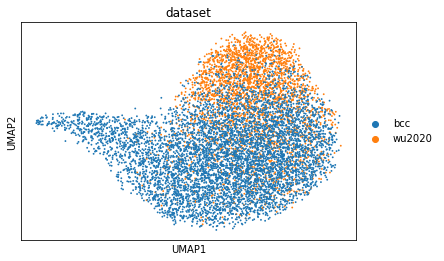

In [27]:
sc.pl.umap(z, color=['dataset'], ncols=1)

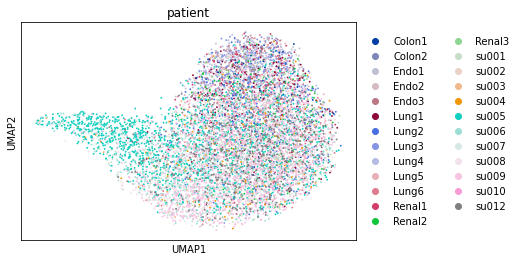

In [28]:
sc.pl.umap(z, color=['patient'])